# **Control Exercise 1: Implementation of P and PI controller in python**

## **Open loop**

Import relevant packages

In [ ]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


Define parameters in a class, to pass into the ODE solver

In [76]:
class Parameters():
    def __init__(self):
        self.Fi = 3.0   # m3/h      Inlet flowrate
        self.Fo0 = 2.0  # m3/h      Outlet flowrate
        self.V0 = 4.0   # m3        Initial Volume in the tank
        self.tspan = (0,10) # h     Time span of the simulation
par = Parameters()   # Create an object with the class Parameters()

In [77]:
## Define the model for open loop simulation of the tank
def tankModel(t:float, x:float, par:dict) -> float:    
    dVdt = par.Fi - par.Fo0    # Model equation
    return dVdt

In [78]:
# Call the ODE solver 
sol = solve_ivp(tankModel, t_span=par.tspan, y0=[par.V0], args=(par,), method='RK45')   

Text(0, 0.5, 'Tank volume [m$^3$]')

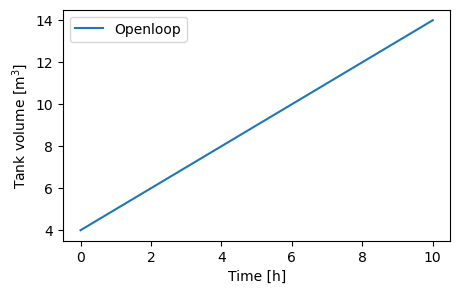

In [79]:
## Plot the results
plt.figure(figsize=(5,3))
plt.plot(sol.t, sol.y[0,:], label='Openloop')
plt.legend()
plt.xlabel('Time [h]')
plt.ylabel('Tank volume [m$^3$]')

## **Closed loop**

In [81]:
# Define tank with P controller
par.V_SP = par.V0       # Volume setpoint
par.PID_Kc = -1         # PID gain
def tankP(t, x, par):
    V = x                               # unpack states (here there is only one state, but important for later...)
    u =  par.PID_Kc*(par.V_SP - V)      # PID equation (only P)
    F0 = par.Fo0 + u                    # Input: outlet flowrate, equal to nominal value + deviation variable (from PID)
    dVdt = par.Fi - F0                  # Model equation
    return dVdt
# Call ODE solver 
solP = solve_ivp(tankP, t_span=par.tspan, y0 = [par.V0], args=(par,), method='BDF')
FoP = par.Fo0+par.PID_Kc*(par.V_SP - solP.y[0,:])      # post compute manipulated variable for plotting



In [82]:
# Define tank with PI controller
par.PID_tauI = 1        # PID Tau_i: integral coefficient
par.I0 = 0              # Initial value for the I computation
par.V_SP = par.V0       # Define volume setpoint

def tankPI(t, x, par):
    V, I = x                            # unpack states
    u = par.PID_Kc*(par.V_SP-V)+I       # PID equation (only PI)
    F0 = par.Fo0 + u                    # Input: outlet flowrate = nominal value + deviation variable from PID
    dVdt = par.Fi - F0                  # model equation
    dIdt = (par.PID_Kc/par.PID_tauI)*(par.V_SP-V)       # I part of the PI controller, to be integrated
    return dVdt, dIdt
# Call ODE solver
solPI = solve_ivp(tankPI, t_span=par.tspan, y0 = [par.V0, par.I0], args=(par,), method='BDF')
FoPI = par.Fo0+par.PID_Kc*(par.V_SP-solPI.y[0,:])+solPI.y[1,:]      # post compute manipulated variable for plotting

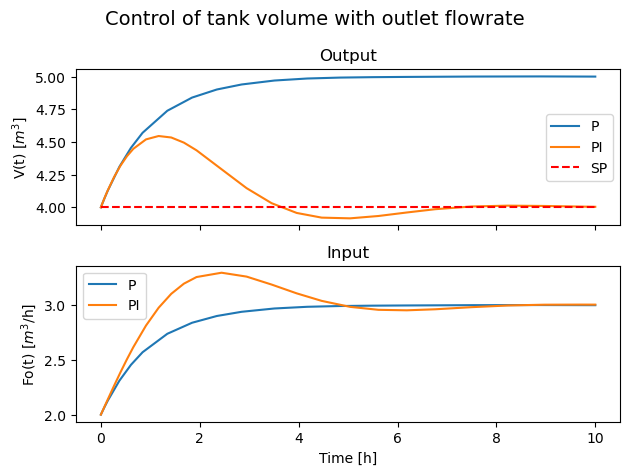

In [90]:
# Plotting
fig, ax = plt.subplots(2,1, sharex=True)
fig.suptitle("Control of tank volume with outlet flowrate", fontsize=14)
ax[0].set_title('Output')
ax[0].plot(solP.t, solP.y[0,:], label='P')
ax[0].plot(solPI.t, solPI.y[0,:], label='PI')
ax[0].plot(par.tspan,[par.V_SP, par.V_SP], '--r', label='SP')
ax[1].plot(solP.t, FoP, label='P')
ax[1].plot(solPI.t, FoPI, label='PI')

ax[1].set_title('Input')
ax[0].set_ylabel('V(t) [$m^3$]')
ax[0].legend()
ax[1].legend()
ax[1].set_ylabel('Fo(t) [$m^3$/h]')
# ax[0].set_xlabel('Time [h]')
ax[1].set_xlabel('Time [h]')
fig.tight_layout()

